# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [3]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [5]:
test_size=52 * 2
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## MAP Fit and Predict

In [7]:
lgt=LGTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [8]:
%%time
lgt.fit(df=train_df)

CPU times: user 202 ms, sys: 14.1 ms, total: 216 ms
Wall time: 427 ms


In [9]:
predicted_df = lgt.predict(df=test_df)

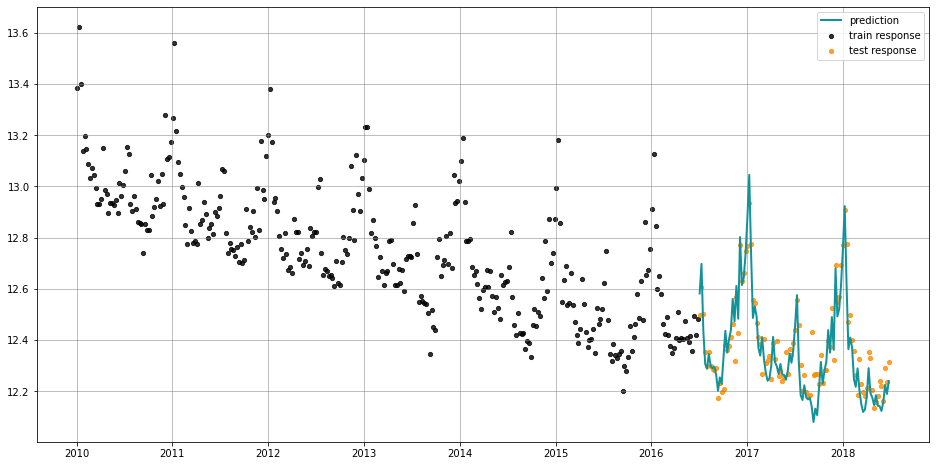

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, test_actual_df=test_df)

## MCMC Fit and Predict

In [11]:
lgt=LGTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
)

In [12]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 71.3 ms, sys: 64.2 ms, total: 135 ms
Wall time: 6.03 s


In [13]:
predicted_df = lgt.predict(df=test_df, decompose=True)

In [14]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
99,2018-05-27,11.931426,12.154117,12.347562,12.144199,12.317793,12.522806,-0.244807,-0.178800,-0.107588,0.0,0.0,0.0
100,2018-06-03,11.946054,12.176364,12.347619,12.110248,12.327646,12.521944,-0.216983,-0.163061,-0.106266,0.0,0.0,0.0
101,2018-06-10,12.058674,12.221358,12.434638,12.141389,12.300029,12.509869,-0.145440,-0.071788,-0.006963,0.0,0.0,0.0
102,2018-06-17,12.002074,12.195525,12.378435,12.130337,12.317905,12.516560,-0.188162,-0.117012,-0.061092,0.0,0.0,0.0
103,2018-06-24,12.017051,12.247574,12.475245,12.106241,12.312243,12.576064,-0.124724,-0.063662,-0.000768,0.0,0.0,0.0


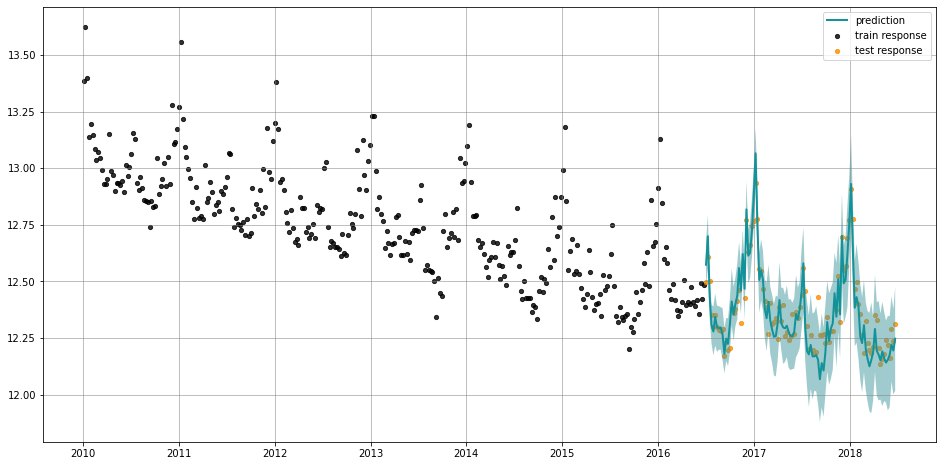

In [15]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df)

## Fit with Regressors & Decmpose Prediction

### Fit with regressors

In [16]:
lgt=LGTFull(
    response_col=response_col,
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=2020,
)

In [17]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 74.5 ms, sys: 69.7 ms, total: 144 ms
Wall time: 6.05 s


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [18]:
# make prediction in both train and test period
predicted_df = lgt.predict(df=df, decompose=True)
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
438,2018-05-27,11.995132,12.148886,12.280278,12.182806,12.349392,12.474016,-0.305456,-0.195003,-0.138374,-0.000516,0.001285,0.003072
439,2018-06-03,12.008827,12.142920,12.332802,12.179141,12.360514,12.470468,-0.308516,-0.187004,-0.117803,0.002007,0.004112,0.006711
440,2018-06-10,12.065896,12.239695,12.368260,12.155612,12.340448,12.468535,-0.185698,-0.100943,-0.034842,0.006338,0.014179,0.021866
441,2018-06-17,12.058627,12.186158,12.366101,12.185954,12.346555,12.475235,-0.256300,-0.156275,-0.070264,0.006232,0.012199,0.020546
442,2018-06-24,12.107207,12.254321,12.427527,12.183719,12.339686,12.505969,-0.204938,-0.097689,-0.035821,0.006146,0.014001,0.020690


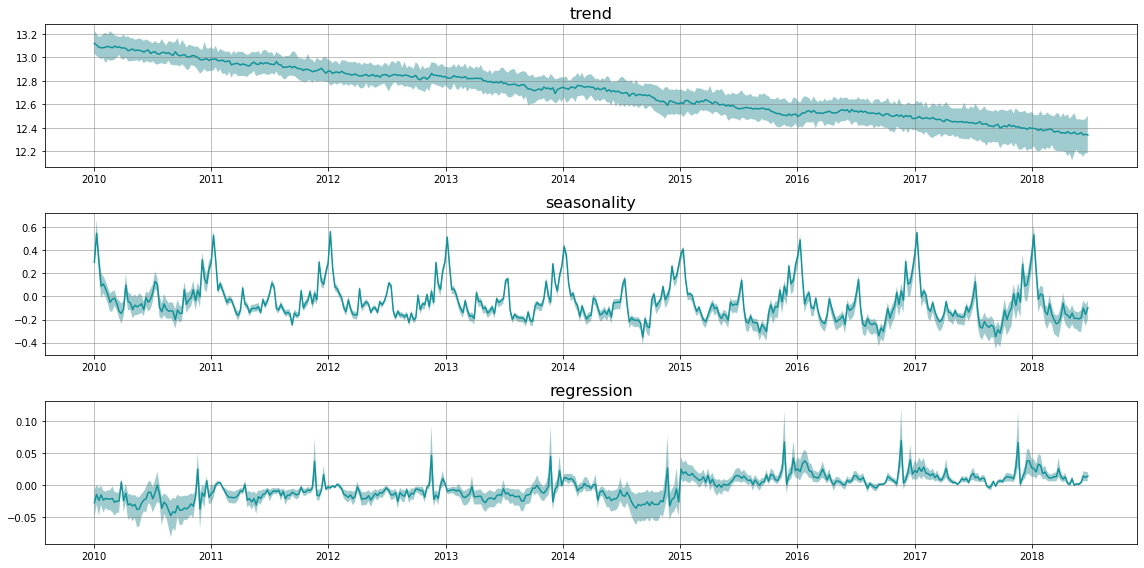

In [19]:
plot_predicted_components(predicted_df=predicted_df, date_col=date_col)